# HW2 — Bike Sharing Demand Prediction (day.csv)

**Follow CRISP-DM**: Business Understanding, Data Understanding, Data Preparation, Modeling, Evaluation, Deployment.

This notebook uses `day.csv` (Kaggle Bike Sharing). **Before running**, set `DATA_PATH` to the full path of your local `day.csv` file (example provided).

**Dataset source (required)**:
- Kaggle example / notebook using the Bike Sharing dataset: https://www.kaggle.com/code/gauravduttakiit/bike-sharing-multiple-linear-regression/input
- Downloaded `day.csv` used in this notebook on: 2025-10-20 (recorded by student)

The dataset has about 16 columns (including target `cnt`). We'll use feature selection (RFE) to pick up to 10 features as required.

## Setup
Install required packages if needed (run once):
```bash
pip install -U scikit-learn pandas matplotlib nbformat scipy statsmodels nbclient
```


## 1. Business Understanding
Predict daily bike rentals (`cnt`) to support operations and resource allocation.

Deliverables required by assignment:
- Use a Kaggle dataset (10–20 features) and cite the link.
- Use Linear Regression; perform Feature Selection & Model Evaluation.
- Include prediction plot with confidence/prediction interval.
- Provide CRISP-DM documentation in report.

## 2. Data Understanding
Load dataset and inspect.

In [53]:
import pandas as pd

# Load dataset
try:
    df = pd.read_csv('day.csv')
    print('Loaded dataset shape:', df.shape)
    display(df.head())
except Exception as e:
    print('Error loading dataset. Please check DATA_PATH. Error:', e)

Loaded dataset shape: (730, 16)


,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,01-01-2018,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,331,654,985
1,2,02-01-2018,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,131,670,801
2,3,03-01-2018,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,4,04-01-2018,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,5,05-01-2018,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600


## 3. Data Preparation
Data Preparation (CRISP-DM): clean data, remove leakage, and prepare features for modeling.
- Drop leaking or unnecessary columns: `instant`, `dteday`, `casual`, `registered`.
- Identify categorical vs numeric features.
- Preprocessing: StandardScaler (numeric) + OneHotEncoder (categorical).

In [54]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# Prepare X, y
cols_to_drop = ['instant','dteday','casual','registered','cnt']
X = df.drop(columns=[c for c in cols_to_drop if c in df.columns])
y = df['cnt']

categorical_features = [c for c in ['season','yr','mnth','holiday','weekday','workingday','weathersit'] if c in X.columns]
numeric_features = [c for c in X.columns if c not in categorical_features]

print('Numeric features:', numeric_features)
print('Categorical features:', categorical_features)

preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), numeric_features),
    ('cat', OneHotEncoder(drop='first'), categorical_features)
])

# Fit preprocessor to get transformed feature names
X_trans = preprocessor.fit_transform(X)
cat_encoder = preprocessor.named_transformers_['cat']
cat_feature_names = list(cat_encoder.get_feature_names_out(categorical_features)) if categorical_features else []
feature_names = numeric_features + cat_feature_names
print('\nTotal features after preprocessing:', len(feature_names))
print(feature_names[:30])

Numeric features: ['temp', 'atemp', 'hum', 'windspeed']
Categorical features: ['season', 'yr', 'mnth', 'holiday', 'weekday', 'workingday', 'weathersit']

Total features after preprocessing: 29
['temp', 'atemp', 'hum', 'windspeed', 'season_2', 'season_3', 'season_4', 'yr_1', 'mnth_2', 'mnth_3', 'mnth_4', 'mnth_5', 'mnth_6', 'mnth_7', 'mnth_8', 'mnth_9', 'mnth_10', 'mnth_11', 'mnth_12', 'holiday_1', 'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6', 'workingday_1', 'weathersit_2', 'weathersit_3']


## 4. Feature Selection (RFE)
We'll use RFE with LinearRegression to select top 10 features (or fewer if fewer exist).

In [55]:
# --- Lasso-based feature selection (LassoCV) ---
from sklearn.linear_model import LassoCV
import pandas as pd

# Transform X to dense array for Lasso (OneHotEncoder may produce sparse output)
X_array = preprocessor.transform(X)
from scipy import sparse as _sparse
if _sparse.issparse(X_array):
    X_array = X_array.toarray()

# Fit Lasso with cross-validation to choose alpha (wider alpha grid)
import numpy as np
alphas = np.logspace(-4, 2, 100)
lasso = LassoCV(alphas=alphas, cv=5, random_state=0, max_iter=10000).fit(X_array, y)

# Apply absolute-coefficient threshold: drop features with |coef| < 200
coef_abs = np.abs(lasso.coef_)
threshold = 200.0
selected_mask = coef_abs >= threshold
selected_mask = np.array(selected_mask, dtype=bool)

# Fallback if no features selected
if not selected_mask.any():
    k = min(10, len(coef_abs))
    top_idx = np.argsort(-coef_abs)[:k]
    mask = np.zeros_like(selected_mask, dtype=bool)
    mask[top_idx] = True
    selected_mask = mask
    print('Note: selected_mask was empty; fell back to top-k selection.')

# Build summary dataframe for inspection
ranking_df = pd.DataFrame({
    'feature': feature_names,
    'coef': lasso.coef_,
    'coef_abs': coef_abs,
    'keep': selected_mask
})

print(f'Threshold = {threshold}; kept {selected_mask.sum()} features, dropped {len(feature_names)-selected_mask.sum()} features.')
print('Kept features:')
print([f for f,k in zip(feature_names, selected_mask) if k])
print('\nDropped features:')
print([f for f,k in zip(feature_names, selected_mask) if not k])

# Show ranked table for manual check
display(ranking_df.sort_values('coef_abs', ascending=False).head(50))


Threshold = 200.0; kept 15 features, dropped 14 features.
Kept features:
['temp', 'atemp', 'hum', 'windspeed', 'season_2', 'season_3', 'season_4', 'yr_1', 'mnth_7', 'mnth_9', 'mnth_10', 'weekday_6', 'workingday_1', 'weathersit_2', 'weathersit_3']

Dropped features:
['mnth_2', 'mnth_3', 'mnth_4', 'mnth_5', 'mnth_6', 'mnth_8', 'mnth_11', 'mnth_12', 'holiday_1', 'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5']


,feature,coef,coef_abs,keep
7,yr_1,1984.587099,1984.587099,True
28,weathersit_3,-1667.852331,1667.852331,True
6,season_4,1274.313590,1274.313590,True
4,season_2,937.814543,937.814543,True
0,temp,734.731653,734.731653,True
15,mnth_9,676.943465,676.943465,True
5,season_3,625.691206,625.691206,True
16,mnth_10,381.838580,381.838580,True
27,weathersit_2,-372.344069,372.344069,True
25,weekday_6,352.496919,352.496919,True


## 5. Modeling
Modeling (CRISP-DM): select algorithm (Linear Regression), train, and validate using hold-out test set.
Train a LinearRegression model using only the selected features. We'll split data into train/test (80/20).

In [56]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
from sklearn.linear_model import LinearRegression

# Build selector transformer
class ColumnSelector:
    def __init__(self, mask):
        self.mask = np.array(mask, dtype=bool)
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        # handle sparse and pandas DataFrame
        if hasattr(X, 'toarray'):
            X = X.toarray()
        X = np.asarray(X)
        return X[:, self.mask]

selector = ColumnSelector(selected_mask)

final_pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('selector', selector), ('lr', LinearRegression())])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
final_pipeline.fit(X_train, y_train)

# predict
y_pred = final_pipeline.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
print(f'RMSE: {rmse:.2f}')
print(f'R2: {r2:.4f}')


RMSE: 685.30
R2: 0.8628


## 6. Evaluation
- Metrics: RMSE, R²
- Top 5 outliers (largest absolute residuals)
- Plots: Actual vs Predicted + 95% prediction intervals

In [57]:
# Residuals and top outliers
residuals = pd.Series(y_test - y_pred, index=y_test.index)
abs_res = residuals.abs().sort_values(ascending=False)
top5 = abs_res.head(5)
print('Top 5 outliers (index : abs residual):')
print(top5)

# Prepare prediction intervals using linear model theory
# Reconstruct design matrix for selected features
X_train_trans = preprocessor.transform(X_train)
# If transform produced a sparse matrix, convert to dense array for design matrix calculations
from scipy import sparse as _sparse
if _sparse.issparse(X_train_trans):
    X_train_trans = X_train_trans.toarray()
X_train_sel = X_train_trans[:, selected_mask]
# Ensure selected slice is 2-D
if getattr(X_train_sel, 'ndim', None) == 1:
    X_train_sel = X_train_sel.reshape(-1, 1)
X_train_design = np.hstack([np.ones((X_train_sel.shape[0],1)), X_train_sel])

# Use pseudo-inverse for stability and check condition number
XtX = X_train_design.T.dot(X_train_design)
cond = np.linalg.cond(XtX)
if cond > 1e12:
    print(f'Warning: X^T X condition number is large ({cond:.2e}) — using pseudo-inverse')
XtX_inv = np.linalg.pinv(XtX)

X_test_trans = preprocessor.transform(X_test)
if _sparse.issparse(X_test_trans):
    X_test_trans = X_test_trans.toarray()
X_test_sel = X_test_trans[:, selected_mask]
if getattr(X_test_sel, 'ndim', None) == 1:
    X_test_sel = X_test_sel.reshape(-1, 1)
X_test_design = np.hstack([np.ones((X_test_sel.shape[0],1)), X_test_sel])

n_train = X_train_design.shape[0]
p = X_train_design.shape[1]

rss = np.sum((y_train - final_pipeline.predict(X_train))**2)
sigma_hat = np.sqrt(rss / (n_train - p))

from scipy.stats import t
tval = t.ppf(0.975, df=n_train - p)
# Classic OLS-based prediction intervals (as implemented earlier)
se_pred = np.array([sigma_hat * np.sqrt(1.0 + x0.reshape(1,-1).dot(XtX_inv).dot(x0.reshape(-1,1))[0,0]) for x0 in X_test_design])
lower = y_pred - tval * se_pred
upper = y_pred + tval * se_pred

print('\nPrediction intervals computed (95%) using OLS formula.')

# --- Additional: statsmodels OLS for coefficient std errors and prediction intervals ---
try:
    import statsmodels.api as sm
    # Fit OLS on training design matrix (includes intercept column)
    sm_model = sm.OLS(y_train.values, X_train_design).fit()
    print('\nStatsmodels OLS summary:')
    print(sm_model.summary())

    # Coefficients table with std err and 95% CI
    coef_table = sm_model.summary2().tables[1].reset_index().rename(columns={'index':'term'})
    print('\nCoefficient estimates with std err and 95% CI (statsmodels):')
    display(coef_table)

    # Use statsmodels to compute prediction intervals for test set (obs_ci gives prediction interval)
    pred = sm_model.get_prediction(X_test_design)
    pred_df = pred.summary_frame(alpha=0.05)  # columns: mean, mean_se, mean_ci_lower/upper, obs_ci_lower/upper
    # Use obs_ci_{lower,upper} as prediction intervals for observations
    if 'obs_ci_lower' in pred_df.columns and 'obs_ci_upper' in pred_df.columns:
        lower_sm = pred_df['obs_ci_lower'].values
        upper_sm = pred_df['obs_ci_upper'].values
        print('\nPrediction intervals computed (95%) using statsmodels (obs_ci).')
        # Overwrite previous lower/upper with statsmodels results for plotting consistency
        lower = lower_sm
        upper = upper_sm
    else:
        print('\nWarning: statsmodels did not return obs_ci columns; keeping OLS-formula intervals.')
except Exception as e:
    print('\nStatsmodels OLS step skipped due to error:', e)


Top 5 outliers (index : abs residual):
265    2357.099700
447    1941.441243
720    1547.632338
196    1528.681778
535    1516.081258
Name: cnt, dtype: float64

Prediction intervals computed (95%) using OLS formula.

Statsmodels OLS summary:
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.837
Model:                            OLS   Adj. R-squared:                  0.832
Method:                 Least Squares   F-statistic:                     194.0
Date:                Mon, 20 Oct 2025   Prob (F-statistic):          5.01e-212
Time:                        22:35:54   Log-Likelihood:                -4724.7
No. Observations:                 584   AIC:                             9481.
Df Residuals:                     568   BIC:                             9551.
Df Model:                          15                                         
Covariance Type:            nonrobust          

,term,Coef.,Std.Err.,t,P>|t|,[0.025,0.975]
0,const,2445.488993,130.021966,18.808276,1.037399e-61,2190.106442,2700.871543
1,x1,579.460895,451.155532,1.284393,1.995282e-01,-306.675919,1465.597709
2,x2,343.236230,446.872463,0.768085,4.427556e-01,-534.487996,1220.960456
3,x3,-223.433505,46.230365,-4.833046,1.732689e-06,-314.236843,-132.630166
4,x4,-221.911046,37.200520,-5.965267,4.297667e-09,-294.978421,-148.843671
5,x5,1209.841126,132.398356,9.137886,1.118661e-18,949.790990,1469.891261
6,x6,819.929236,179.756024,4.561345,6.230866e-06,466.861572,1172.996901
7,x7,1314.904347,116.690584,11.268299,1.014181e-26,1085.706620,1544.102073
8,x8,1965.279141,67.391782,29.162000,5.718847e-115,1832.911621,2097.646660
9,x9,-313.049599,147.686021,-2.119697,3.446469e-02,-603.126990,-22.972208



Prediction intervals computed (95%) using statsmodels (obs_ci).


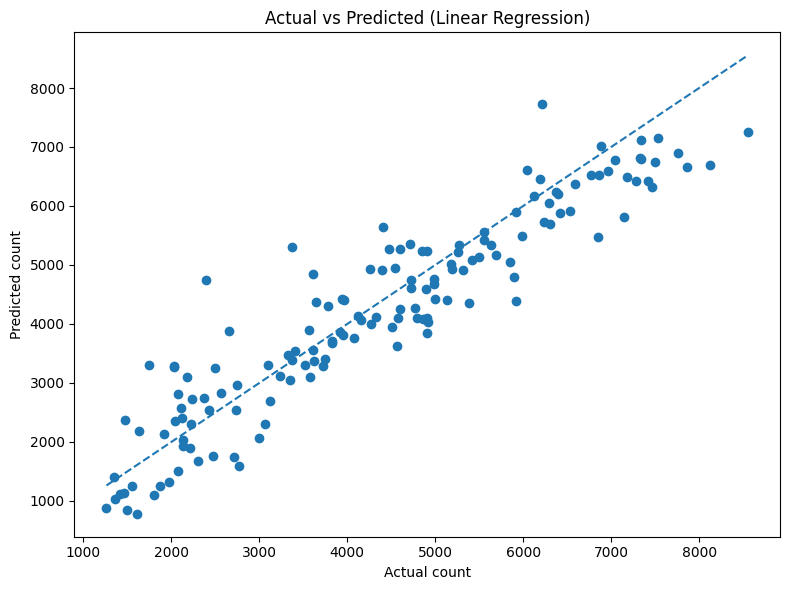

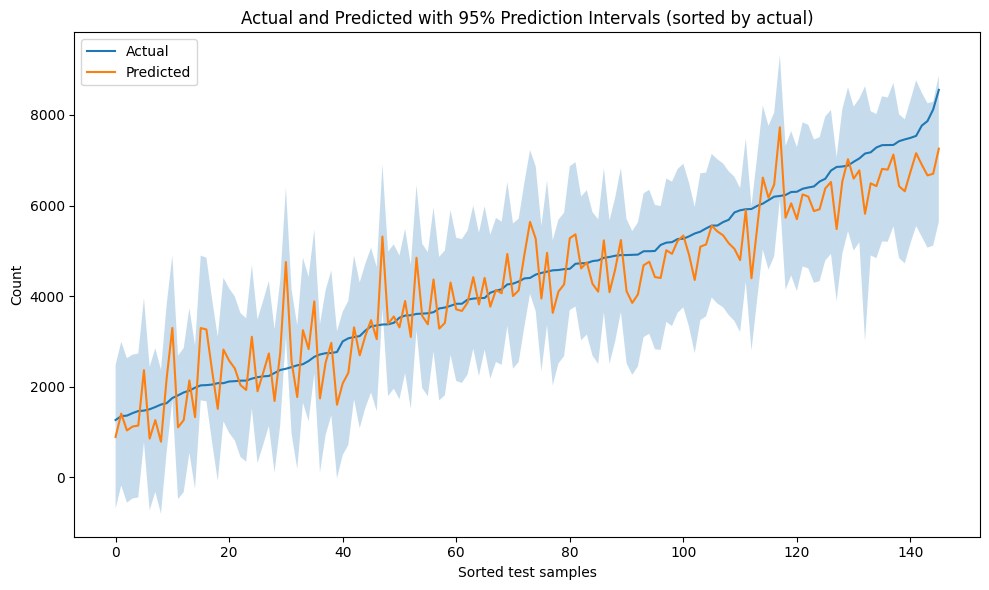

In [58]:
# Plot Actual vs Predicted with prediction intervals
import matplotlib.pyplot as plt

# Scatter Actual vs Predicted
plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], linestyle='--')
plt.xlabel('Actual count')
plt.ylabel('Predicted count')
plt.title('Actual vs Predicted (Linear Regression)')
plt.tight_layout()
plt.show()

# Sorted plot with intervals
order = np.argsort(y_test.values)
plt.figure(figsize=(10,6))
plt.plot(range(len(y_test)), y_test.values[order], label='Actual')
plt.plot(range(len(y_test)), y_pred[order], label='Predicted')
plt.fill_between(range(len(y_test)), lower[order].flatten(), upper[order].flatten(), alpha=0.25)
plt.legend()
plt.title('Actual and Predicted with 95% Prediction Intervals (sorted by actual)')
plt.xlabel('Sorted test samples')
plt.ylabel('Count')
plt.tight_layout()
plt.show()